## 基础数据处理

1. 从2024年的文件中
2. 获得后复权因子
3. 将所有股票原始数据拼接成按股票的单一文件，每个文件包含上市以来的所有股票数据
4. 数据检查和异常处理


### 获取所有股票代码

In [1]:
import os
import json

# Define the updated function to modify the filenames as required
def get_ticker_with_prefix(path):
    tickers = []
    for f in os.listdir(path):
        if f.endswith('.csv'):
            # Extract numeric part
            numeric_part = ''.join(filter(str.isdigit, f))
            # Extract the letter part (.SZ or .SH), convert to lowercase and prepend to the numeric part
            letter_part = f.split('.')[1].lower()
            #ticker = letter_part + numeric_part
            ticker = numeric_part
            tickers.append(ticker)
    # Sort the list of IDs
    return sorted(tickers)

# Replace 'path_to_folder' with the actual path to your folder containing the CSV files
path_to_folder = 'data/raw-data/2024'

# Get the modified stock ids
tickers_with_prefix = get_ticker_with_prefix(path_to_folder)

# Convert the list of modified stock ids to JSON format
json_content = json.dumps(tickers_with_prefix, indent=4)

# Replace 'path_to_json_file' with the actual path where you want to save the JSON file
path_to_json_file = 'data/tickers.json'

# Write the JSON content to a file
with open(path_to_json_file, 'w') as json_file:
    json_file.write(json_content)

### 测试后复权因子

In [ ]:
import akshare as ak

df = ak.stock_zh_a_daily("sz001872", adjust="hfq-factor")
df

### 获取后复权因子并进行预处理

In [5]:
import akshare as ak
import json
import os
import concurrent.futures
from tqdm import tqdm
import pandas as pd

def get_and_save_data(ticker):
    filename = f"{ticker}.csv"
    # 检查文件是否存在
    if not os.path.exists("data/backward_adjust_factor/" + filename):
        # 如果ticker开头是0或3，增加sz前缀，否则增加sh前缀
        if ticker.startswith('0') or ticker.startswith('3'):
            ticker_prefixed = 'sz' + ticker
        else:
            ticker_prefixed = 'sh' + ticker
            
        try:
            # 尝试调用 API 获取数据
            df = ak.stock_zh_a_daily(symbol=ticker_prefixed, adjust="hfq-factor")
            df['hfq_factor'] = pd.to_numeric(df['hfq_factor'], errors='coerce')
            # 数据处理
            df['hfq_one_point'] = df['hfq_factor'] / df['hfq_factor'].shift(-1)
            df['hfq_one_point'].fillna(1.0, inplace=True)
            # 保存数据到 CSV 文件
            df.to_csv("data/backward_adjust_factor/" + filename, index=False)
            return ticker, None
        except Exception as e:
            return ticker, e
    else:
        return ticker, "File already exists"

def main():
    path_to_json_file = 'data/tickers.json'
    with open(path_to_json_file, 'r') as json_file:
        tickers = json.load(json_file)

    error_tickers = []

    max_workers = max(1, os.cpu_count() - 1)  # 保留一个CPU核心
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 使用 tqdm 显示进度条
        results = list(tqdm(executor.map(get_and_save_data, tickers), total=len(tickers)))
        
        for ticker, error in results:
            if error and error != "File already exists":
                error_tickers.append(ticker)
                print(f"Error retrieving data for {ticker}: {error}")
            else:
                print(f"{ticker} data processed successfully")

    # 打印出错的 ticker 并保存至文件
    print(f"Error tickers: {error_tickers}")
    with open("data/backward_adjust_factor/error_tickers.txt", 'w') as f:
        for ticker in error_tickers:
            f.write(f"{ticker}\n")

if __name__ == "__main__":
    main()


  0%|          | 0/5100 [00:00<?, ?it/s]

100%|██████████| 5100/5100 [01:07<00:00, 76.08it/s] 

000001 data processed successfully
000002 data processed successfully
000004 data processed successfully
000005 data processed successfully
000006 data processed successfully
000007 data processed successfully
000008 data processed successfully
000009 data processed successfully
000010 data processed successfully
000011 data processed successfully
000012 data processed successfully
000014 data processed successfully
000016 data processed successfully
000017 data processed successfully
000019 data processed successfully
000020 data processed successfully
000021 data processed successfully
000023 data processed successfully
000025 data processed successfully
000026 data processed successfully
000027 data processed successfully
000028 data processed successfully
000029 data processed successfully
000030 data processed successfully
000031 data processed successfully
000032 data processed successfully
000034 data processed successfully
000035 data processed successfully
000036 data processe

### 按股票合并历年数据<多线程>

In [8]:
import os
import pandas as pd
import json
import concurrent.futures
from tqdm import tqdm

# 路径设置
json_file = 'data/tickers.json'
data_dir = 'data/raw-data/'
merged_dir = 'data/by_stock_merged/'
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

# 读取股票代码列表
with open(json_file, 'r') as f:
    tickers = json.load(f)

def merge_data_for_ticker(ticker):
    # 检查合并后的文件是否已存在
    output_file = os.path.join(merged_dir, f"{ticker}.csv")
    if os.path.isfile(output_file):
        return  # 如果已存在，则跳过这个股票
    
    all_data = []  # 存储单个股票的所有数据
    # 遍历每个年份的文件夹
    for year in os.listdir(data_dir):
        year_dir = os.path.join(data_dir, year)
        if os.path.isdir(year_dir):  # 确保是目录
            # 假设后缀可能是.SZ或.SH，尝试两种可能性
            for suffix in ['.SZ', '.SH']:
                file_path = os.path.join(year_dir, f"{ticker}{suffix}.csv")
                if os.path.isfile(file_path):  # 确保文件存在
                    data = pd.read_csv(file_path)
                    all_data.append(data)
                    break
    
    if all_data:
        # 合并数据
        merged_data = pd.concat(all_data)
        # 按交易时间排序
        merged_data.sort_values(by='trade_time', inplace=True)
        # 保存到merged文件夹
        merged_data.to_csv(os.path.join(merged_dir, f"{ticker}.csv"), index=False)

def main():
    max_workers = max(1, os.cpu_count() - 1)  # 保留一个CPU核心
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 设置tqdm进度条
        futures = [executor.submit(merge_data_for_ticker, ticker) for ticker in tickers]
        for _ in tqdm(concurrent.futures.as_completed(futures), total=len(tickers), desc="Merging Stocks"):
            pass

if __name__ == "__main__":
    main()


Merging Stocks: 100%|██████████| 5100/5100 [00:12<00:00, 410.69it/s]


### 单只股票数据检查<多线程>

In [1]:
import pandas as pd
from pathlib import Path
import concurrent.futures
import os
from tqdm import tqdm

def check_data_points_and_nan(file_path):
    df = pd.read_csv(file_path)
    df['trade_time'] = pd.to_datetime(df['trade_time'])
    df['date'] = df['trade_time'].dt.date
    grouped = df.groupby('date').size()

    ticker = Path(file_path).stem  # 获取文件名作为股票代码
    invalid_dates = grouped[grouped != 240].index.tolist()
    nan_values = df.isna().any(axis=1)

    if invalid_dates or nan_values.any():
        return ticker, invalid_dates, df[nan_values]

    return None

def main():
    folder_path = 'data/by_stock_merged/'
    file_paths = Path(folder_path).glob('*.csv')

    max_workers = max(1, os.cpu_count() - 1)  # 保留一个CPU核心
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(check_data_points_and_nan, file_paths), total=len(file_paths)))
       
        for result in results:
            if result:
                ticker, invalid_dates, nan_data = result
                print(f'Ticker: {ticker}, Invalid Dates: {invalid_dates}')
                if not nan_data.empty:
                    print(f'Non-numeric data found in Ticker: {ticker}')

if __name__ == "__main__":
    main()

Ticker: 000638, Invalid Dates: []
Non-numeric data found in Ticker: 000638
Ticker: 000995, Invalid Dates: []
Non-numeric data found in Ticker: 000995


### 异常数据处理

In [9]:
import pandas as pd
import os

files = [
    '000638.csv',
    '000995.csv'
]
file_folder = 'data/by_stock_merged/'
return_folder = 'data/by_stock_return_rate/'

for file in files:
    file_path = file_folder + file
    df = pd.read_csv(file_path)

    df = df[df.loc[:, 'open':'amount'].notna().any(axis=1) | df['trade_time'].isna()]    # 去掉空值
    df = df[df['trade_time'] != '2023-11-30 13:00:00']  # 去掉2023-11-30 13:00:00这一行
    df = df.drop_duplicates(subset='trade_time')    # 去掉重复行

    df.to_csv(file_path, index=False)

    # 如果文件存在，则删除by_stock_return_rate中的对应文件
    return_file_path = return_folder + file
    if os.path.exists(return_file_path):
        os.remove(return_file_path)



## 换手率和流通市值

需求：获取按年按股票的 日平均换手率 年底总市值和年底流通市值
代码：
1. 从akshare获取换手率和成交额数据
2. 整理成需求格式 <没有找到总市值数据接口>

20240208新需求：每年根据总成交量排序，获得后10%tickers

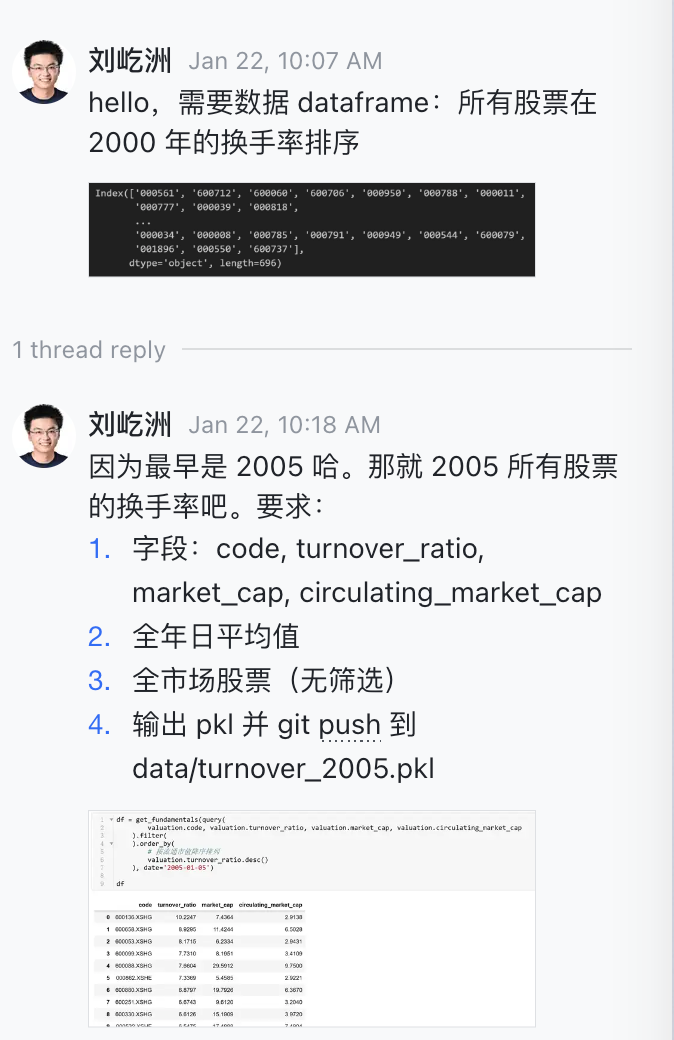

### 获取历年流动性<多线程>

In [1]:
import os
import akshare as ak
import json
import pandas as pd
import numpy as np
import concurrent.futures
from tqdm import tqdm

def process_stock_data(year, ticker):
    # Prepare start and end dates
    start_date = f"{year}0101"
    end_date = f"{year}1231"

    try:
        # Fetch data from akshare
        turnover = ak.stock_zh_a_hist(symbol=ticker, start_date=start_date, end_date=end_date, adjust='')[['换手率']]
        amount = ak.stock_zh_a_hist(symbol=ticker, start_date=start_date, end_date=end_date, adjust='')[['成交额']]

        if turnover.empty or amount.empty:
            return None

        trading_days = len(turnover)
        daily_average_turnover = turnover['换手率'].mean() / 100
        circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
        total_amount = amount['成交额'].sum()  # total amount added 20240208

        return [ticker, daily_average_turnover, circulating_market_cap, trading_days, total_amount]

    except Exception as e:
        return None

def main():
    try:
        with open('data/tickers.json') as f:
            tickers = json.load(f)
    except Exception as e:
        print(f"Error reading tickers file: {e}")
        return

    years = range(2000, 2024)
    max_workers = max(1, os.cpu_count() - 1)  # 保留一个CPU核心

    turnover_dir = 'data/turnover'
    if not os.path.exists(turnover_dir):
        os.makedirs(turnover_dir)

    for year in years:
        filename = os.path.join(turnover_dir, f'turnovers_{year}.csv')
        if os.path.exists(filename):
            print(f"Data for {year} already exists. Skipping...")
            continue

        results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # 在这里为每个ticker创建一个进度条
            futures = {executor.submit(process_stock_data, year, ticker): ticker for ticker in tickers}
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(tickers), desc=f"Processing {year}"):
                result = future.result()
                if result:
                    results.append(result)

        if results:
            df = pd.DataFrame(results, columns=['tickers', 'turnover_ratio', 'circulating_market_cap', 'trading_days', 'amount'])
            df.set_index('tickers', inplace=True)
            df.sort_values(by='tickers', ascending=True, inplace=True)
            df.to_csv(filename)
            df.to_pickle(os.path.join(turnover_dir, f'turnovers_{year}.pkl'))
            print(f"Data for {year} saved to {filename}")

if __name__ == "__main__":
    main()

/home/xliu_thu_gmail_com/.local/lib/python3.8/site-packages/akshare/__init__.py:2687: UserWarning: 为了支持更多特性，请将 Python 升级到 3.9.0 及以上版本！
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Processing 2000:   1%|          | 29/5100 [00:05<16:35,  5.09it/s] 


### 获取历年流动性<一次性下载所有年份数据，多线程>

In [2]:
import os
import akshare as ak
import json
import pandas as pd
import numpy as np
import concurrent.futures
from tqdm import tqdm

def fetch_and_process_stock_data(ticker):
    # 设置整个时间范围
    start_date = "20000101"
    end_date = "20241231"
    
    try:
        # 从akshare获取全部时间范围内的数据
        data = ak.stock_zh_a_hist(symbol=ticker, start_date=start_date, end_date=end_date, adjust='')
        return ticker, data
    except Exception as e:
        return ticker, None

def process_yearly_data(ticker, data):
    # 处理每年的数据
    results = []
    if data is not None and not data.empty:
        # 转换日期格式，以便于按年分组
        data['日期'] = pd.to_datetime(data['日期'])
        for year, group in data.groupby(data['日期'].dt.year):
            turnover = group[['换手率']]
            amount = group[['成交额']]

            if turnover.empty or amount.empty:
                continue

            trading_days = len(turnover)
            daily_average_turnover = turnover['换手率'].mean() / 100
            circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
            total_amount = amount['成交额'].sum()
            daily_average_amount = total_amount / trading_days  # 计算日均成交额

            results.append([ticker, year, daily_average_turnover, circulating_market_cap, trading_days, total_amount, daily_average_amount])
    return results

def main():
    try:
        with open('data/tickers.json') as f:
            tickers = json.load(f)
    except Exception as e:
        print(f"Error reading tickers file: {e}")
        return

    max_workers = max(1, os.cpu_count() - 1)  # 保留一个CPU核心
    turnover_dir = 'data/turnover'
    if not os.path.exists(turnover_dir):
        os.makedirs(turnover_dir)

    all_results = []  # 用于收集所有年份、所有股票的数据

    # 下载并处理每个股票的数据
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_and_process_stock_data, ticker): ticker for ticker in tickers}
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(tickers), desc="Downloading"):
            ticker, data = future.result()
            if data is not None:
                # 处理每年的数据并收集结果
                yearly_results = process_yearly_data(ticker, data)
                all_results.extend(yearly_results)
                
    # 按年份分组并保存每年的数据
    if all_results:
        df_all = pd.DataFrame(all_results, columns=['tickers', 'year', 'turnover_ratio', 'circulating_market_cap', 'trading_days', 'amount', 'daily_average_amount'])
        for year, group in df_all.groupby('year'):
            filename = os.path.join(turnover_dir, f'turnovers_{year}.csv')
            group.drop(columns=['year'], inplace=True)  # 移除year列
            group.set_index(['tickers'], inplace=True)
            group.sort_values(by=['tickers'], ascending=True, inplace=True)
            group.to_csv(filename)
            print(f"Data for {year} saved to {filename}")

if __name__ == "__main__":
    main()


Downloading:   0%|          | 0/5100 [00:00<?, ?it/s]

Downloading:   4%|▍         | 224/5100 [00:20<06:56, 11.71it/s]/tmp/ipykernel_46511/3972643535.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
Downloading:   5%|▍         | 237/5100 [00:21<05:26, 14.88it/s]/tmp/ipykernel_46511/3972643535.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
Downloading:  49%|████▉     | 2517/5100 [02:19<03:55, 10.96it/s]/tmp/ipykernel_46511/3972643535.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
Downloading:  50%|████▉     | 2547/5100 [02:22<04:16,  9.95it/s]/tmp/ipykernel_46511/3972643535.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  circulating_market_cap = amount['成交额'].iloc[-1] / turnover['换手率'].iloc[-1] * 100
Downloading:  50%|

Data for 2000 saved to data/turnover/turnovers_2000.csv
Data for 2001 saved to data/turnover/turnovers_2001.csv
Data for 2002 saved to data/turnover/turnovers_2002.csv
Data for 2003 saved to data/turnover/turnovers_2003.csv
Data for 2004 saved to data/turnover/turnovers_2004.csv
Data for 2005 saved to data/turnover/turnovers_2005.csv
Data for 2006 saved to data/turnover/turnovers_2006.csv
Data for 2007 saved to data/turnover/turnovers_2007.csv
Data for 2008 saved to data/turnover/turnovers_2008.csv
Data for 2009 saved to data/turnover/turnovers_2009.csv
Data for 2010 saved to data/turnover/turnovers_2010.csv
Data for 2011 saved to data/turnover/turnovers_2011.csv
Data for 2012 saved to data/turnover/turnovers_2012.csv
Data for 2013 saved to data/turnover/turnovers_2013.csv
Data for 2014 saved to data/turnover/turnovers_2014.csv
Data for 2015 saved to data/turnover/turnovers_2015.csv
Data for 2016 saved to data/turnover/turnovers_2016.csv
Data for 2017 saved to data/turnover/turnovers_2

### 在流动性表格中，根据某一项数值（需求中是交易额）筛选排名后90%的股票

In [5]:
import os
import pandas as pd
import json

evaluation_indicator = 'daily_average_amount'  # Change this to your evaluation indicator
ratio = 0.1  # Change this to your ratio

years = range(2000, 2024)
turnover_dir = 'data/turnover'

lowest_percent_tickers = []

for year in years:
    filename = os.path.join(turnover_dir, f'turnovers_{year}.csv')
    if os.path.exists(filename):
        # Ensure tickers are read as strings to preserve leading zeros
        df = pd.read_csv(filename, dtype={'tickers': str})
        df.set_index('tickers', inplace=True)
        df.sort_values(by=evaluation_indicator, ascending=True, inplace=True)

        # Get the tickers of the lowest percent stocks
        lowest_percent = int(len(df) * ratio)
        lowest_percent_tickers.extend(df.index[:lowest_percent].tolist())

# Remove duplicates
lowest_percent_tickers = list(set(lowest_percent_tickers))

# Save the tickers to a json file in the same directory as the data source
with open(os.path.join(turnover_dir, 'drop_tickers.json'), 'w') as f:
    json.dump(lowest_percent_tickers, f)

# The final print statements will only be accurate if at least one file was processed.
# Ensure that a DataFrame 'df' exists before attempting to print.
if 'df' in locals():
    print(f"Total number of stocks: {len(df)}")
    print(f"Number of stocks filtered out: {len(lowest_percent_tickers)}")
    print(f"Ratio of stocks filtered out: {len(lowest_percent_tickers) / len(df)}")
    print(f"Tickers of the lowest {ratio*100}% stocks for each year have been saved to 'lowest_percent_tickers.json'.")
else:
    print("No turnover data files were processed.")


Total number of stocks: 5096
Number of stocks filtered out: 2177
Ratio of stocks filtered out: 0.4271978021978022
Tickers of the lowest 10.0% stocks for each year have been saved to 'lowest_percent_tickers.json'.


## 合并所有股票数据作为训练数据

### 1. 将合并后的单支股票数据处理为单支股票收益率数据

#### 按股票计算收益率并进行后复权处理<多线程>

In [1]:
import pandas as pd
import os
import glob
import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import multiprocessing

# 定义后复权处理函数
def process_hfq_data(stock_data, hfq_data_path, ticker, period, period_dict):
    filename = f'{ticker}.csv'
    file_path = os.path.join(hfq_data_path, filename)
    
    if os.path.exists(file_path):
        hfq_data = pd.read_csv(file_path)
        hfq_data['date'] = pd.to_datetime(hfq_data['date'])
        file_found = True
    else:
        print(f'No hfq_one_point data file found for ticker {ticker}. Skipping...')
        return None

    if file_found:
        stock_data['trade_time'] = pd.to_datetime(stock_data['trade_time'])
        stock_data['return_rate'] = stock_data['close'].pct_change().fillna(0)

        for index, row in hfq_data[hfq_data['date'] > '2000-01-01'].iterrows():
            if period == '1d':
                trade_time = row['date'].date()
            else:
                minutes = period_dict[period]
                additional_hours, additional_minutes = divmod(30 + minutes, 60)
                trade_time = row['date'] + datetime.timedelta(hours=9 + additional_hours, minutes=additional_minutes)

            mask = (stock_data['trade_time'].dt.date == trade_time) if period == '1d' else (stock_data['trade_time'] == trade_time)

            if mask.any():
                stock_data.loc[mask, 'return_rate'] = (stock_data.loc[mask, 'return_rate'] + 1) * row['hfq_one_point'] - 1

        return stock_data[['trade_time', 'return_rate']]  # 仅保留交易时间和收益率

# 处理单个文件
def process_file(file_path, output_folder, hfq_data_path, period, period_dict):
    ticker = os.path.basename(file_path).split('.')[0]
    output_file_path = os.path.join(output_folder, os.path.basename(file_path))

    if os.path.exists(output_file_path):
        # print(f"Output for {ticker} already exists. Skipping...")
        return

    stock_data = pd.read_csv(file_path)
    processed_data = process_hfq_data(stock_data, hfq_data_path, ticker, period, period_dict)
    if processed_data is not None:
        processed_data.to_csv(output_file_path, index=False)

# 修改后的主函数
def main(input_folder, output_folder, hfq_data_path, period, period_dict):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    file_paths = glob.glob(os.path.join(input_folder, '*.csv'))

    # 获取CPU核心数，并保留一个核心不使用
    max_workers = max(1, multiprocessing.cpu_count() - 1)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_file, file_path, output_folder, hfq_data_path, period, period_dict) for file_path in file_paths]
        for future in tqdm(as_completed(futures), total=len(file_paths)):
            future.result()
# 定义不同周期的分钟数
period_dict = {
    '1m': 1,
    '5m': 5,
    # ... 其他周期
}

input_folder = 'data/by_stock_merged'
output_folder = 'data/by_stock_return_rate'
hfq_data_path = 'data/backward_adjust_factor'
period = '1m'

if __name__ == "__main__":
    main(input_folder, output_folder, hfq_data_path, period, period_dict)


 96%|█████████▌| 4871/5100 [30:32<00:48,  4.67it/s]  

No hfq_one_point data file found for ticker 689009. Skipping...


100%|██████████| 5100/5100 [32:48<00:00,  2.59it/s]


#### 收益率数据检查<多线程>

In [1]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def process_file(file_name, callback):
    issues = []
    file_path = os.path.join(folder_path, file_name)
    ticker = file_name.split('.')[0]  # 获取股票ticker
    
    # 读取CSV文件
    try:
        data = pd.read_csv(file_path)
        
        # 检查是否每天有240条数据
        daily_counts = data['trade_time'].str.slice(0, 10).value_counts()
        for date, count in daily_counts.items():
            if count != 240:
                issues.append({'ticker': ticker, 'trade_time': 'N/A', 'date': date})
        
        # 检查return_rate是否有NaN、空值、非数字值、或者数据异常
        for index, row in data.iterrows():
            if pd.isnull(row['return_rate']) or not isinstance(row['return_rate'], (int, float)) or abs(row['return_rate']) > 0.1:
                issues.append({'ticker': ticker, 'trade_time': row['trade_time'], 'date': row['trade_time'][:10]})
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

    # 调用回调函数来更新进度条
    callback()
    return issues

# 指定数据文件夹路径
folder_path = 'data/by_stock_return_rate/' # 更改到你的数据文件夹路径

# 获取系统CPU核心数量
num_cpus = os.cpu_count()

# 准备一个空的DataFrame来记录问题数据
issues_df = pd.DataFrame(columns=['ticker', 'trade_time', 'date'])

# 使用一个CPU核心数减一的线程池
with ThreadPoolExecutor(max_workers=max(1, num_cpus-1)) as executor:
    # 获取所有CSV文件名
    file_names = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.csv')]
    # 设置进度条
    progress = tqdm(total=len(file_names), desc="Processing files")

    # 提交任务到线程池，并提供一个回调函数来更新进度条
    futures = []
    for file_name in file_names:
        future = executor.submit(process_file, file_name, lambda: progress.update(1))
        futures.append(future)

    # 等待所有任务完成
    for future in as_completed(futures):
        issues = future.result()
        for issue in issues:
            issues_df = issues_df.append(issue, ignore_index=True)

    # 关闭进度条
    progress.close()

# 写入问题记录到新的CSV文件
output_path = 'data/return_rate_issues_report.csv' # 更改到你的输出路径
issues_df.to_csv(output_path, index=False)


Processing files:   0%|          | 0/5099 [00:00<?, ?it/s]

Processing files:   5%|▍         | 239/5099 [1:42:06<40:12:58, 29.79s/it] 

### 2. 按照每五年流动性前70%合并股票数据作为训练数据输入

#### 提取流动性最好的股票tickers

提取tickers

In [1]:
import pandas as pd
import os
import json

# Define a function to process the turnover data
def process_turnover_data(input_dir, output_dir):
    # Create a directory for output if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get all CSV file paths
    csv_files = [file for file in os.listdir(input_dir) if file.endswith('.csv')]

    # Sort files to ensure they are processed in order
    csv_files.sort()

    # Process each 5-year period
    for period_start in range(2000, 2025, 5):
        period_end = period_start + 4
        period_tickers = set()

        # Process each year in the 5-year period
        for year in range(period_start, period_end + 1):
            file_name = f'turnovers_{year}.csv'
            if file_name in csv_files:
                # Read the CSV file
                df = pd.read_csv(os.path.join(input_dir, file_name), dtype={'tickers': str})

                # Calculate the 70th percentile of the turnover ratio
                threshold = df['turnover_ratio'].quantile(0.7)

                # Filter tickers that meet the criteria
                year_tickers = df[(df['turnover_ratio'] >= threshold) & (df['trading_days'] >= 100)]['tickers']

                # Add the tickers to the period set if not already present
                period_tickers.update(year_tickers)

        # Save the period tickers to a JSON file
        with open(os.path.join(output_dir, f'tickers_{period_start}-{period_end}.json'), 'w') as f:
            json.dump(list(period_tickers), f)

# Directories for input and output
input_dir = 'data/turnover'  # Update this path to your local directory containing the CSV files
output_dir = 'data/turnover'  # Update this path to your desired output directory

# Call the function to process the data
process_turnover_data(input_dir, output_dir)


统计每个json中有多少ticker

In [4]:
import json
import os


def count_tickers_in_json(output_dir):
    # Find all JSON files in the directory
    json_files = [file for file in os.listdir(output_dir) if file.endswith('.json')]
    
    # Initialize a dictionary to store the count of tickers for each period
    ticker_counts = {}

    # Go through each JSON file and count the tickers
    for json_file in json_files:
        # Open and load the JSON file
        with open(os.path.join(output_dir, json_file), 'r') as f:
            tickers = json.load(f)
            # Get the period from the file name (assuming file name format is 'tickers_STARTYEAR-ENDYEAR.json')
            period = json_file.replace('tickers_', '').replace('.json', '')
            # Count the number of tickers in this period
            ticker_counts[period] = len(tickers)
    
    return ticker_counts

# We'll use the previously defined output directory to count the tickers
output_dir = 'data/turnover'

# Call the function and print the results
ticker_counts = count_tickers_in_json(output_dir)
ticker_counts


{'2015-2019': 2159,
 '2005-2009': 940,
 '2000-2004': 811,
 '2010-2014': 1402,
 '2020-2024': 2956}

#### 合并股票数据

In [2]:
import pandas as pd
import os
from tqdm import tqdm
import json

def merge_csv_files(folder_path, output_folder, column, tickers, start_date, end_date):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    merged_data = pd.DataFrame()
    files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and os.path.splitext(file)[0] in tickers]

    for file in tqdm(files, desc='Merging files with column ' + column):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=['trade_time'])
        # Filter the data to only include rows within the date range for the current period
        df = df[(df['trade_time'] >= start_date) & (df['trade_time'] <= end_date)]
        file_name = os.path.splitext(file)[0]
        df.rename(columns={column: file_name}, inplace=True)
        df = df[['trade_time', file_name]]
        
        if merged_data.empty:
            merged_data = df
        else:
            # Merge without forward filling
            merged_data = pd.merge_ordered(merged_data, df, on='trade_time')

    output_file = os.path.join(output_folder, f'merged_{column}_{start_date.year}-{end_date.year}.csv')
    merged_data.to_csv(output_file, index=False)

def merge_for_periods(input_folder, output_folder, periods_folder, column):
    # Get all JSON file paths
    json_files = [file for file in os.listdir(periods_folder) if file.endswith('.json')]

    for json_file in json_files:
        period = os.path.splitext(json_file)[0].split('_')[-1]
        start_year, end_year = map(int, period.split('-'))
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)

        with open(os.path.join(periods_folder, json_file), 'r') as f:
            tickers = json.load(f)

        print(f'Merging {column} for period {period}')
        merge_csv_files(input_folder, output_folder, column, tickers, start_date, end_date)

columns = [
    'return_rate',
    # 'close',
    # 'open',
    # 'high',
    # 'low', 
    # 'vol', 
    # 'amount'
    ]
input_folder = 'data/by_stock_return_rate'  # Update this path to your local directory containing the CSV files
output_folder = 'data/merged_return_rate/'  # Update this path to your desired output directory
periods_folder = 'data/turnover/'  # Update this path to your directory containing the JSON ticker files

for column in columns:
    merge_for_periods(input_folder, output_folder, periods_folder, column)
    print(f'Merged {column} successfully!')


Merging return_rate for period 2015-2019


Merging files with column return_rate:   0%|          | 0/2159 [00:00<?, ?it/s]

Merging files with column return_rate: 100%|██████████| 2159/2159 [42:29<00:00,  1.18s/it]


Merging return_rate for period 2005-2009


Merging files with column return_rate: 100%|██████████| 940/940 [20:33<00:00,  1.31s/it]


Merging return_rate for period 2000-2004


Merging files with column return_rate: 100%|██████████| 811/811 [17:52<00:00,  1.32s/it]


Merging return_rate for period 2010-2014


Merging files with column return_rate: 100%|██████████| 1402/1402 [27:44<00:00,  1.19s/it]


Merging return_rate for period 2020-2024


Merging files with column return_rate: 100%|██████████| 2956/2956 [52:07<00:00,  1.06s/it]


Merged return_rate successfully!


#### 数据检验

切片

In [3]:
import pandas as pd
file_path = 'data/merged_return_rate/merged_return_rate_2000-2004.csv'
df = pd.read_csv(file_path)

# extract the first 5 columns
df = df.iloc[:, :5]
df.to_csv('data/merged_return_rate/merged_return_rate_2000-2004_test.csv', index=False)

检查数据形状和每日数据点数

In [4]:
import pandas as pd
import os

file_path = 'data/merged_return_rate/merged_return_rate_2000-2004_test.csv'
df = pd.read_csv(file_path)
print(df.shape)

# 检查是否每天有240个数据点
df['trade_time'] = pd.to_datetime(df['trade_time'])
df['date'] = df['trade_time'].dt.date
grouped = df.groupby('date').size()
result = grouped == 240
print(result)

invalid_dates = grouped[grouped != 240].index.tolist()
for i in invalid_dates:
    print(i, grouped[i])



(287760, 5)
date
2000-01-04    True
2000-01-05    True
2000-01-06    True
2000-01-07    True
2000-01-10    True
              ... 
2004-12-24    True
2004-12-27    True
2004-12-28    True
2004-12-29    True
2004-12-30    True
Length: 1199, dtype: bool


csv转pkl

In [5]:
import pandas as pd
import os
from zipfile import ZipFile

# 为每个CSV文件和对应的PKL.ZIP文件定义文件名前缀
csv_prefixes = ['2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2024']
pkl_prefixes = ['2000', '2005', '2010', '2015', '2020']

# 文件夹路径
folder_path = 'data/merged_return_rate/'

# 循环处理每个文件
for csv_prefix, pkl_prefix in zip(csv_prefixes, pkl_prefixes):
    csv_file_path = os.path.join(folder_path, f'merged_return_rate_{csv_prefix}.csv')
    pkl_zip_file_path = os.path.join(folder_path, f'stock_returns_1m_{pkl_prefix}.pkl.zip')

    # 读取CSV文件
    df = pd.read_csv(csv_file_path)
    
    # 将 'trade_time' 设置为索引
    df.set_index('trade_time', inplace=True)
    
    # 保存修改后的DataFrame回原CSV文件
    df.to_csv(csv_file_path)
    
    # 直接保存DataFrame为压缩的PKL文件
    df.to_pickle(pkl_zip_file_path, compression='zip')
    
    print(f'Processed {csv_file_path} and {pkl_zip_file_path}')


所有文件已转换完成。


In [1]:
import pandas as pd
import os

file_path = 'data/merged_return_rate/stock_returns_1m_2000.pkl.zip'
df = pd.read_pickle(file_path, compression='zip')
print (df.head())

                     000968  600658  002001  000961  600577    000028  \
trade_time                                                              
2000-01-04 09:31:00     NaN     0.0     NaN     NaN     NaN  0.000000   
2000-01-04 09:32:00     NaN     0.0     NaN     NaN     NaN  0.007421   
2000-01-04 09:33:00     NaN     0.0     NaN     NaN     NaN  0.003683   
2000-01-04 09:34:00     NaN     0.0     NaN     NaN     NaN  0.026606   
2000-01-04 09:35:00     NaN     0.0     NaN     NaN     NaN  0.000000   

                       000638    600000    000920  600522  ...  600499  \
trade_time                                                 ...           
2000-01-04 09:31:00  0.000000  0.000000  0.000000     NaN  ...     NaN   
2000-01-04 09:32:00  0.000000  0.000801 -0.002135     NaN  ...     NaN   
2000-01-04 09:33:00 -0.001447 -0.000400  0.000000     NaN  ...     NaN   
2000-01-04 09:34:00 -0.011594 -0.003601  0.000000     NaN  ...     NaN   
2000-01-04 09:35:00  0.000000  0.000000 -0.0

### 3. 合并所有股票数据

#### 数据合并<单线程，弃用>

In [ ]:
import pandas as pd
import os
from tqdm import tqdm

def merge_all_csv_files(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    merged_data = pd.DataFrame()
    files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    for file in tqdm(files, desc='Merging files'):
        ticker = os.path.splitext(file)[0]  # Extract ticker from the file name
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=['trade_time'])
        df.set_index('trade_time', inplace=True)
        df.rename(columns={df.columns[0]: ticker}, inplace=True)  # Assume the first column is the one we want to keep and rename it to ticker
        
        if merged_data.empty:
            merged_data = df
        else:
            merged_data = pd.merge_ordered(merged_data, df, on='trade_time')

    output_file = os.path.join(output_folder, 'merged_all.csv')
    merged_data.to_csv(output_file)

# Configuration
input_folder = 'data/by_stock_return_rate'  
output_folder = 'data/merged_return_rate/'  

# Merge process
merge_all_csv_files(input_folder, output_folder)
print('All files merged successfully with trade_time as index and tickers as column headers!')


#### 数据合并<多线程>

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

def merge_files_in_group(file_group, folder_path, output_folder, group_index):
    print(f"Group {group_index+1}: Merging {len(file_group)} files...")
    merged_data = pd.DataFrame()
    for file in tqdm(file_group, desc=f'Merging files in Group {group_index+1}'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=['trade_time'])
        df.set_index('trade_time', inplace=True)
        ticker = os.path.splitext(file)[0]  # Extract ticker from file name
        df.rename(columns={df.columns[0]: ticker}, inplace=True)
        
        if merged_data.empty:
            merged_data = df
        else:
            merged_data = pd.merge_ordered(merged_data, df, on='trade_time')
    
    # Save merged data to disk
    intermediate_file = os.path.join(output_folder, f'intermediate_group_{group_index+1}.csv')
    merged_data.to_csv(intermediate_file)
    print(f"Group {group_index+1}: Merge complete and saved to {intermediate_file}.")
    return intermediate_file

def merge_all_csv_files(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    num_cpus = multiprocessing.cpu_count() - 1  # Number of CPUs minus 1
    print(f"Number of groups: {num_cpus}")
    file_groups = [files[i::num_cpus] for i in range(num_cpus)]  # Split files into groups

    intermediate_files = []
    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = [executor.submit(merge_files_in_group, group, folder_path, output_folder, i) for i, group in enumerate(file_groups)]
        for future in as_completed(futures):
            intermediate_files.append(future.result())

    print("Merging intermediate results...")
    final_merged_data = pd.DataFrame()
    for file in tqdm(intermediate_files, desc='Final merging'):
        df = pd.read_csv(file, index_col='trade_time', parse_dates=['trade_time'])
        if final_merged_data.empty:
            final_merged_data = df
        else:
            final_merged_data = pd.merge_ordered(final_merged_data, df, on='trade_time')

    # Remove intermediate files to free up disk space
    for file in intermediate_files:
        os.remove(file)
        print(f"Removed intermediate file {file}")

    output_file = os.path.join(output_folder, 'merged_all.csv')
    final_merged_data.to_csv(output_file)
    print("Final merge complete. Output file saved.")

# Configuration
input_folder = 'data/by_stock_return_rate'
output_folder = 'data/merged_return_rate/'

# Merge process
merge_all_csv_files(input_folder, output_folder)
print('All files merged successfully with trade_time as index and tickers as column headers!')



Number of groups: 29
Group 1: Merging 176 files...
Group 2: Merging 176 files...
Group 3: Merging 176 files...
Group 4: Merging 176 files...
Group 5: Merging 176 files...
Group 6: Merging 176 files...
Group 7: Merging 176 files...
Group 8: Merging 176 files...
Group 9: Merging 176 files...
Group 10: Merging 176 files...
Group 11: Merging 176 files...
Group 12: Merging 176 files...


Merging files in Group 1:   0%|          | 0/176 [00:00<?, ?it/s]

Group 13: Merging 176 files...
Group 14: Merging 176 files...
Group 15: Merging 176 files...
Group 16: Merging 176 files...
Group 17: Merging 176 files...
Group 18: Merging 176 files...


Group 19: Merging 176 files...
Group 20: Merging 176 files...
Group 21: Merging 176 files...
Group 22: Merging 176 files...
Group 23: Merging 176 files...
Group 24: Merging 176 files...
Group 25: Merging 175 files...
Group 26: Merging 175 files...
Group 27: Merging 175 files...
Group 28: Merging 175 files...


Group 29: Merging 175 files...


Merging files in Group 2:   0%|          | 0/176 [00:00<?, ?it/s]











































































































































































Merging files in Group 1:   1%|          | 1/176 [00:01<01:25,  2.06it/s]















































































































Merging files in Group 1:   1%|          | 2/176 [00:07<11:29,  3.96s/it]






































































































































































































Merging files in Group 1:   2%|▏         | 3/176 [00:26<30:35, 10.61s/it]






























































































































































Merging files in Group 1:   2%|▏         | 4/176 [00:39<34:15, 11.95s/it]







































































Group 21: Merge complete and saved to data/merged_return_rate/intermediate_group_21.csv.
Group 7: Merge complete and saved to data/merged_return_rate/intermediate_group_7.csv.
Group 8: Merge complete and saved to data/merged_return_rate/intermediate_group_8.csv.
Group 17: Merge complete and saved to data/merged_return_rate/intermediate_group_17.csv.
Group 29: Merge complete and saved to data/merged_return_rate/intermediate_group_29.csv.
Group 9: Merge complete and saved to data/merged_return_rate/intermediate_group_9.csv.
Group 11: Merge complete and saved to data/merged_return_rate/intermediate_group_11.csv.
Group 23: Merge complete and saved to data/merged_return_rate/intermediate_group_23.csv.
Group 5: Merge complete and saved to data/merged_return_rate/intermediate_group_5.csv.
Group 3: Merge complete and saved to data/merged_return_rate/intermediate_group_3.csv.
Group 16: Merge complete and saved to data/merged_return_rate/intermediate_group_16.csv.
Group 28: Merge complete and sa

Final merging:  10%|█         | 3/29 [01:52<16:13, 37.45s/it]


MergeError: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} is not allowed.

#### 如果多线程数据没有合并成功，但是中间数据已经完整生成，使用下面代码合并中间数据

In [1]:
import pandas as pd
import os
from tqdm import tqdm

def final_merge(output_folder, final_output_file):
    intermediate_files = [file for file in os.listdir(output_folder) if file.startswith('intermediate_group_')]
    print(f"Found {len(intermediate_files)} intermediate files to merge.")

    final_merged_data = pd.DataFrame()
    for file in tqdm(intermediate_files, desc='Final merging'):
        file_path = os.path.join(output_folder, file)
        # 确保第一列被用作索引，避免产生'Unnamed: 0'列
        df = pd.read_csv(file_path, index_col=0, parse_dates=['trade_time'])
        if final_merged_data.empty:
            final_merged_data = df
        else:
            # 使用pd.merge_ordered以保持时间序列的有序性
            final_merged_data = pd.merge_ordered(final_merged_data, df, on='trade_time', fill_method='ffill')

    final_output_path = os.path.join(output_folder, final_output_file)
    final_merged_data.to_csv(final_output_path)
    print(f"Final merge complete. Output file saved to {final_output_path}.")

    # Optionally, remove intermediate files to free up disk space
    for file in intermediate_files:
        os.remove(os.path.join(output_folder, file))
        print(f"Removed intermediate file {file}")

# 调用函数进行最终合并
output_folder = 'data/merged_return_rate/'  # 你的中间文件存储位置
final_output_file = 'merged_all.csv'  # 最终合并后的文件名
final_merge(output_folder, final_output_file)


Found 29 intermediate files to merge.


Final merging:   0%|          | 0/29 [00:00<?, ?it/s]

Final merging: 100%|██████████| 29/29 [34:37<00:00, 71.63s/it] 


Final merge complete. Output file saved to data/merged_return_rate/final_merged_all.csv.
Removed intermediate file intermediate_group_14.csv
Removed intermediate file intermediate_group_15.csv
Removed intermediate file intermediate_group_25.csv
Removed intermediate file intermediate_group_27.csv
Removed intermediate file intermediate_group_29.csv
Removed intermediate file intermediate_group_22.csv
Removed intermediate file intermediate_group_13.csv
Removed intermediate file intermediate_group_4.csv
Removed intermediate file intermediate_group_26.csv
Removed intermediate file intermediate_group_23.csv
Removed intermediate file intermediate_group_3.csv
Removed intermediate file intermediate_group_8.csv
Removed intermediate file intermediate_group_9.csv
Removed intermediate file intermediate_group_17.csv
Removed intermediate file intermediate_group_10.csv
Removed intermediate file intermediate_group_12.csv
Removed intermediate file intermediate_group_6.csv
Removed intermediate file interm

#### 数据检查

切片

In [ ]:
import pandas as pd
file_path = 'data/merged_return_rate/merged_all.csv'
df = pd.read_csv(file_path)

# extract the first 5 columns
df = df.iloc[:, :5]
df.to_csv('data/merged_return_rate/merged_all_test.csv', index=False)

In [ ]:
chunk_size = 3*10**5
chunks = pd.read_csv(file_path, chunksize=chunk_size)

for chunk in chunks:
    chunk = chunk.iloc[:, :5]
    chunk.to_csv('data/merged_return_rate/merged_all_test.csv', mode='a', index=False, header=not os.path.exists('data/merged_return_rate/merged_all_test.csv'))


检验数据形状

In [ ]:
import pandas as pd
import os

file_path = 'data/merged_return_rate/merged_all_test.csv'
df = pd.read_csv(file_path)
print(df.shape)

# 检查是否每天有240个数据点
df['trade_time'] = pd.to_datetime(df['trade_time'])
df['date'] = df['trade_time'].dt.date
grouped = df.groupby('date').size()
result = grouped == 240
print(result)

invalid_dates = grouped[grouped != 240].index.tolist()
for i in invalid_dates:
    print(i, grouped[i])



转格式

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

csv_file_path = 'data/merged_return_rate/merged_all.csv'
pkl_zip_file_path = 'data/merged_return_rate/stock_returns_1m_all.pkl.zip'

df = pd.read_csv(csv_file_path)
df.to_pickle(pkl_zip_file_path, compression='zip')

print(f'Processed {pkl_zip_file_path}')

In [ ]:
import pandas as pd
import os

file_path = 'data/merged_return_rate/stock_returns_1m_all.pkl.zip'
df = pd.read_pickle(file_path, compression='zip')
print (df.head())

## 将一分钟数据处理为其他间隔的分钟数据

In [1]:
import pandas as pd

data_path = 'data/stock_returns_1m_all.pkl'
df = pd.read_pickle(data_path)

print(df)

                     301515  601238  605222  002011  688048  002483  002949  \
trade_time                                                                    
2000-01-04 09:31:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:32:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:33:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:34:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     300439    000042  603200  ...  600400  001965  300203  \
trade_time                                     ...                           
2000-01-04 09:31:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:32:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:33:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:34:00     NaN  0.000000     NaN  ...     N

In [3]:
resample_time_series = {
    "5m": 5,
    "15m": 15,
    "30m": 30,
    "1h": 60,
    "1d": 240
}

for period, minutes in resample_time_series.items():
    df_resampled = df.iloc[minutes-1::minutes, :].copy()
    
    if period == "1d":
        df_resampled.reset_index(inplace=True)
        df_resampled['trade_time'] = pd.to_datetime(df_resampled['trade_time'])
        df_resampled['trade_time'] = df_resampled['trade_time'].dt.date
        df_resampled.rename(columns={'trade_time': 'date'}, inplace=True)
        df_resampled.set_index('date', inplace=True)

    df_resampled.to_pickle(f'data/stock_returns_{period}_all.pkl.zip', compression='zip')

In [4]:
file_path = f'data/stock_returns_5m_all.pkl.zip'
df = pd.read_pickle(file_path, compression='zip')
print(df)

                       301515    601238    605222   002011    688048  \
trade_time                                                             
2000-01-04 09:35:00       NaN       NaN       NaN      NaN       NaN   
2000-01-04 09:40:00       NaN       NaN       NaN      NaN       NaN   
2000-01-04 09:45:00       NaN       NaN       NaN      NaN       NaN   
2000-01-04 09:50:00       NaN       NaN       NaN      NaN       NaN   
2000-01-04 09:55:00       NaN       NaN       NaN      NaN       NaN   
...                       ...       ...       ...      ...       ...   
2024-01-12 14:40:00  0.000366  0.001176  0.000000  0.00000  0.000374   
2024-01-12 14:45:00  0.000000  0.001175 -0.000536 -0.00076 -0.000374   
2024-01-12 14:50:00  0.000000  0.001176  0.000000  0.00000  0.000000   
2024-01-12 14:55:00 -0.001464 -0.001176  0.000537 -0.00076  0.000187   
2024-01-12 15:00:00  0.000000  0.000000  0.000000  0.00076  0.003379   

                       002483    002949    300439    000042    

In [5]:
file_path = f'data/stock_returns_1h_all.pkl.zip'
df = pd.read_pickle(file_path, compression='zip')
print(df)

                       301515    601238    605222    002011    688048  \
trade_time                                                              
2000-01-04 10:30:00       NaN       NaN       NaN       NaN       NaN   
2000-01-04 11:30:00       NaN       NaN       NaN       NaN       NaN   
2000-01-04 14:00:00       NaN       NaN       NaN       NaN       NaN   
2000-01-04 15:00:00       NaN       NaN       NaN       NaN       NaN   
2000-01-05 10:30:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2024-01-11 15:00:00 -0.000716  0.001172  0.000000  0.000752  0.000000   
2024-01-12 10:30:00 -0.000713  0.001167  0.001064  0.000000  0.000738   
2024-01-12 11:30:00  0.000000  0.001175 -0.001071  0.000000  0.000560   
2024-01-12 14:00:00 -0.000365 -0.001176  0.001074 -0.000760 -0.001124   
2024-01-12 15:00:00  0.000000  0.000000  0.000000  0.000760  0.003379   

                       002483    002949    300439 

In [6]:
file_path = f'data/stock_returns_1d_all.pkl.zip'
df = pd.read_pickle(file_path, compression='zip')
print(df)

              301515    601238    605222    002011    688048    002483  \
date                                                                     
2000-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-01-08  0.002136  0.000000 -0.002732 -0.000767  0.000752  0.000000   
2024-01-09 -0.000361  0.000000  0.001088  0.000000  0.001317 -0.003929   
2024-01-10 -0.000365 -0.002384 -0.000537  0.000774 -0.000578  0.000000   
2024-01-11 -0.000716  0.001172  0.000000  0.000752  0.000000  0.001946   
2024-01-12  0.000000  0.000000  0.000000  0.000760  0.003379 -0.001934   

              002949    300439    000